In [35]:
from src.prepare import telco_model_prep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier

import eli5

## Prredicting Telco Churn
#### 1. Preprocessing
#### 2. Modeling

In [2]:
telco_df = telco_model_prep()

In [3]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   tenure                                 7043 non-null   int64  
 2   MonthlyCharges                         7043 non-null   float64
 3   TotalCharges                           7043 non-null   float64
 4   gender_Male                            7043 non-null   uint8  
 5   Partner_Yes                            7043 non-null   uint8  
 6   Dependents_Yes                         7043 non-null   uint8  
 7   PhoneService_Yes                       7043 non-null   uint8  
 8   MultipleLines_Yes                      7043 non-null   uint8  
 9   InternetService_Fiber_optic            7043 non-null   uint8  
 10  InternetService_No                     7043 non-null   uint8  
 11  Onli

In [4]:
telco_df.head(1)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber_optic,...,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One_year,Contract_Two_year,PaperlessBilling_Yes,PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check,Churn_Yes
0,0,1,29.85,29.85,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


## Preprocessing

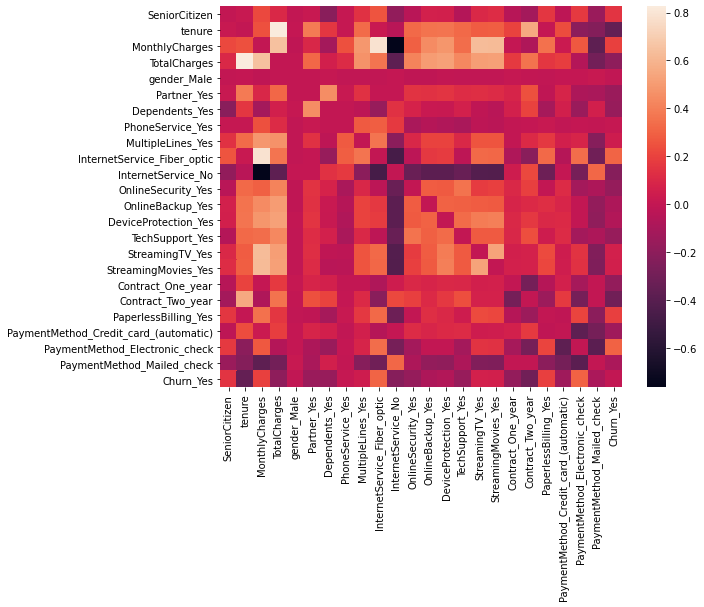

In [5]:
plt.figure(figsize=(9,7))
corr_mat = telco_df.corr()
np.fill_diagonal(corr_mat.values, 0) #we don't care about self-corralation
sns.heatmap(corr_mat);

Multicollinearity can be detected via various methods. The most common one – VIF (Variable Inflation Factors).

    ” VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable. “

    or

    VIF score of an independent variable represents how well the variable is explained by other independent variables.

* VIF starts at 1 and has no upper limit
* VIF = 1, no correlation between the independent variable and the other variables
* VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others


In [6]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [7]:
calc_vif(telco_df)

,variables,VIF
0,SeniorCitizen,1.378648
1,tenure,20.301634
2,MonthlyCharges,219.462335
3,TotalCharges,21.470433
4,gender_Male,2.021570
5,Partner_Yes,2.827182
6,Dependents_Yes,1.977410
7,PhoneService_Yes,47.753112
8,MultipleLines_Yes,2.859843
9,InternetService_Fiber_optic,17.770660


In [8]:
telco_df = telco_df.drop(['MonthlyCharges', 'PhoneService_Yes', 'InternetService_No',
                          'TotalCharges'], axis=1)

In [9]:
calc_vif(telco_df)

,variables,VIF
0,SeniorCitizen,1.368336
1,tenure,7.259814
2,gender_Male,1.869879
3,Partner_Yes,2.809132
4,Dependents_Yes,1.940324
5,MultipleLines_Yes,2.308981
6,InternetService_Fiber_optic,2.933686
7,OnlineSecurity_Yes,1.764942
8,OnlineBackup_Yes,1.998671
9,DeviceProtection_Yes,2.169982


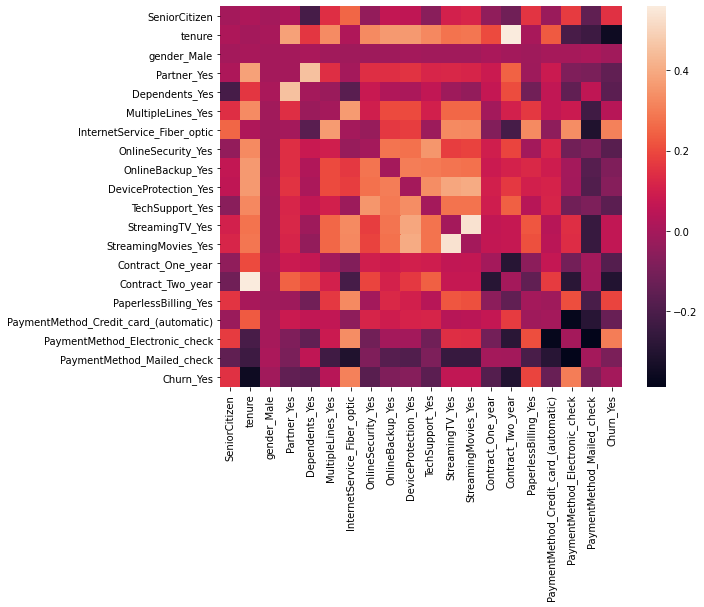

In [10]:
plt.figure(figsize=(9,7))
corr_mat = telco_df.corr()
np.fill_diagonal(corr_mat.values, 0) #we don't care about self-corralation
sns.heatmap(corr_mat);

### Oversampling & Train-Val-Test Split

In [11]:
#isolate the response variable
churn = telco_df.pop("Churn_Yes")

In [12]:
#make a test set before scaling or oversampling the data
X_train, X_test, y_train, y_test = train_test_split(telco_df, churn, test_size=15/100,
                                                    random_state=36, stratify=churn)

In [13]:
churn.value_counts()

0    5174
1    1869
Name: Churn_Yes, dtype: int64

In [14]:
# define random oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
#X_train, y_train = oversample.fit_resample(X_train, y_train)
#or synthetic kNN data
smote = SMOTE(random_state=36)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [15]:
y_train.value_counts() #oversampling the churn class

0    4397
1    4397
Name: Churn_Yes, dtype: int64

In [16]:
#divide X_train and y_train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/85,
                                                    random_state=36, stratify=y_train)

In [17]:
X_train.shape, X_test.shape, X_val.shape, y_test.shape, y_train.shape, y_val.shape

((7242, 19), (1057, 19), (1552, 19), (1057,), (7242,), (1552,))

## Modeling

In [18]:
#baseline: no churn
#tp / (tp + fp) is precision
#tp / (tp + fn) is recall
print(f"Accuracy: {1 - sum(y_test)/len(y_test)}")
print(f"Precision: {sum(y_test)/(sum(y_test)+0)}")
print(f"Recall: {sum(y_test)/(sum(y_test+0))}")
print(classification_report(y_test, np.zeros(len(y_test))))

Accuracy: 0.7350993377483444
Precision: 1.0
Recall: 1.0
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       777
           1       0.00      0.00      0.00       280

    accuracy                           0.74      1057
   macro avg       0.37      0.50      0.42      1057
weighted avg       0.54      0.74      0.62      1057



/Users/stevennewton/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stevennewton/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stevennewton/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Why not predict all zeros?

Low recall is a big problem. Accuracy is a distraction with imbalanced classes. The model isn't picking up on why customers leave, which is the whole point of the analysis.

Imagine churn jumps from 74% to 90%. The dumb model will be doing excellent and the business will be insolvent.

Why not predict all ones?

Karl Popper — 'A theory that explains everything, explains nothing'

THis model is the boy who cried wolf. You have to focus resources on something, or else you will accomplish nothing. Giving equal attention to the 3/4 of satisifed customers will not address the high-value, high-risk customers leaving every month.

### Non-linear classifiers

In [19]:
#kNN benefited from the SMOTEing on dev set
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform').fit(X_train, y_train)
f"kNN accuracy: {knn.score(X_val, y_val)}"

'kNN accuracy: 0.7931701030927835'

In [20]:
dt = DecisionTreeClassifier(random_state=36).fit(X_train, y_train)
f"Overfit decision tree accuracy: {dt.score(X_val, y_val)}"

'Overfit decision tree accuracy: 0.7944587628865979'

In [21]:
#ccp_alpha prunes weak links based on impurity, a useless, 100% impure node splits evenly (50/50) whereas a 100% pure node classifies all samples to one class
dt = DecisionTreeClassifier(ccp_alpha=.005, random_state=36).fit(X_train, y_train)
f"Decision tree accuracy: {dt.score(X_val, y_val)}"

'Decision tree accuracy: 0.7557989690721649'

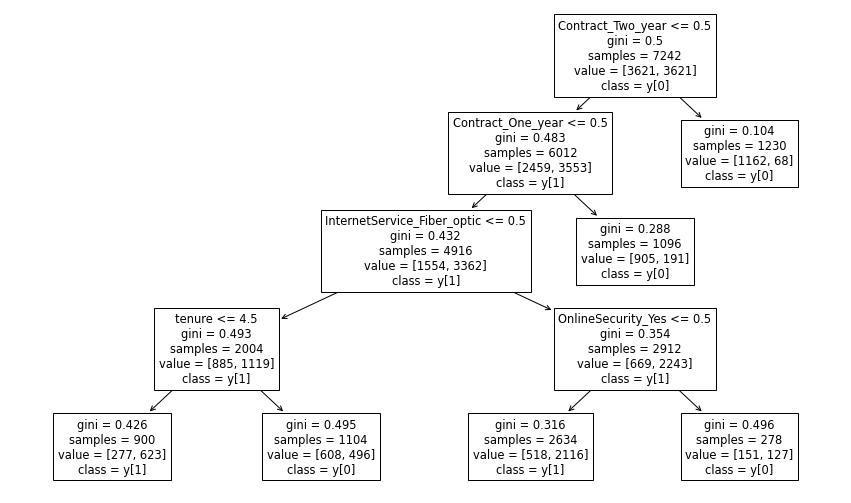

In [22]:
plt.figure(figsize=(15,9))
plot_tree(dt, feature_names=X_val.columns, class_names=True);

In [23]:
rf = RandomForestClassifier(random_state=36).fit(X_train, y_train)
f"Overfit random forest accuracy: {rf.score(X_val, y_val)}"

'Overfit random forest accuracy: 0.8273195876288659'

In [24]:
#without oversampling, recall for churn was a dismal .26
rf = RandomForestClassifier(ccp_alpha=.005, random_state=36).fit(X_train, y_train)
print(classification_report(y_val, rf.predict(X_val)))
f"Random forest accuracy: {rf.score(X_val, y_val)}"

              precision    recall  f1-score   support

           0       0.80      0.72      0.76       776
           1       0.74      0.82      0.78       776

    accuracy                           0.77      1552
   macro avg       0.77      0.77      0.77      1552
weighted avg       0.77      0.77      0.77      1552



'Random forest accuracy: 0.7699742268041238'

In [25]:
#ranked importance based on Gini index
eli5.show_weights(rf, feature_names=list(X_val.columns))

Weight,Feature
0.2531 ± 0.3698,Contract_Two_year
0.1849 ± 0.3315,tenure
0.1359 ± 0.2398,InternetService_Fiber_optic
0.1345 ± 0.2310,Contract_One_year
0.0966 ± 0.2219,OnlineSecurity_Yes
0.0678 ± 0.2195,PaymentMethod_Electronic_check
0.0348 ± 0.1371,TechSupport_Yes
0.0313 ± 0.1220,Dependents_Yes
0.0229 ± 0.1126,Partner_Yes
0.0114 ± 0.0611,PaymentMethod_Credit_card_(automatic)


### Linear classifiers

In [26]:
#wasn't converging at first because of collinearity
#again, oversampling gives big boost to churn recall, .51 to .85
#accuracy doesn't tell the story: baseline is 74% accurate with 
lr = make_pipeline(StandardScaler(),LogisticRegression(random_state=36))
#lr = LogisticRegression(random_state=36)
lr.fit(X_train, y_train)
print(classification_report(y_val, lr.predict(X_val)))
f"Logistic regression accuracy: {lr.score(X_val, y_val)}"

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       776
           1       0.75      0.84      0.79       776

    accuracy                           0.78      1552
   macro avg       0.78      0.78      0.78      1552
weighted avg       0.78      0.78      0.78      1552



'Logistic regression accuracy: 0.7777061855670103'

In [27]:
eli5.show_weights(lr, feature_names=list(X_val.columns))

Weight?,Feature
+0.418,InternetService_Fiber_optic
+0.156,StreamingMovies_Yes
+0.112,StreamingTV_Yes
+0.111,PaperlessBilling_Yes
+0.012,MultipleLines_Yes
-0.040,DeviceProtection_Yes
-0.056,SeniorCitizen
-0.107,Partner_Yes
-0.130,OnlineBackup_Yes
-0.160,PaymentMethod_Electronic_check


In [28]:
sgd = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-5, random_state=36)).fit(X_train, y_train)
f"Stochastic gradient descent accuracy: {sgd.score(X_val, y_val)}"

'Stochastic gradient descent accuracy: 0.7667525773195877'

In [29]:
rr = make_pipeline(StandardScaler(),
                   RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=3)).fit(X_train, y_train)
f"Ridge regression accuracy: {rr.score(X_val, y_val)}"

'Ridge regression accuracy: 0.7751288659793815'